<a href="https://colab.research.google.com/github/Jashvanth18/SIRA-Eval/blob/main/Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy matplotlib torch scipy sympy scikit-learn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Running deterministic SIR simulation...


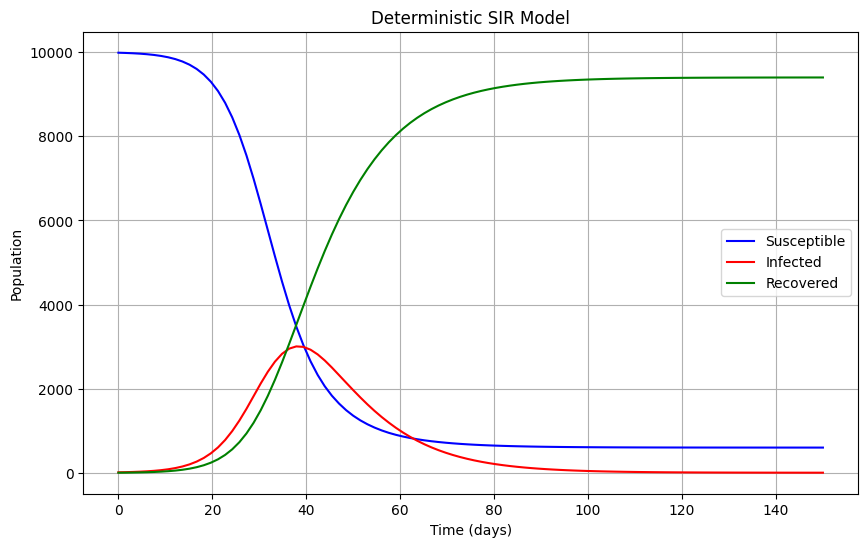

Running stochastic SIR simulation...


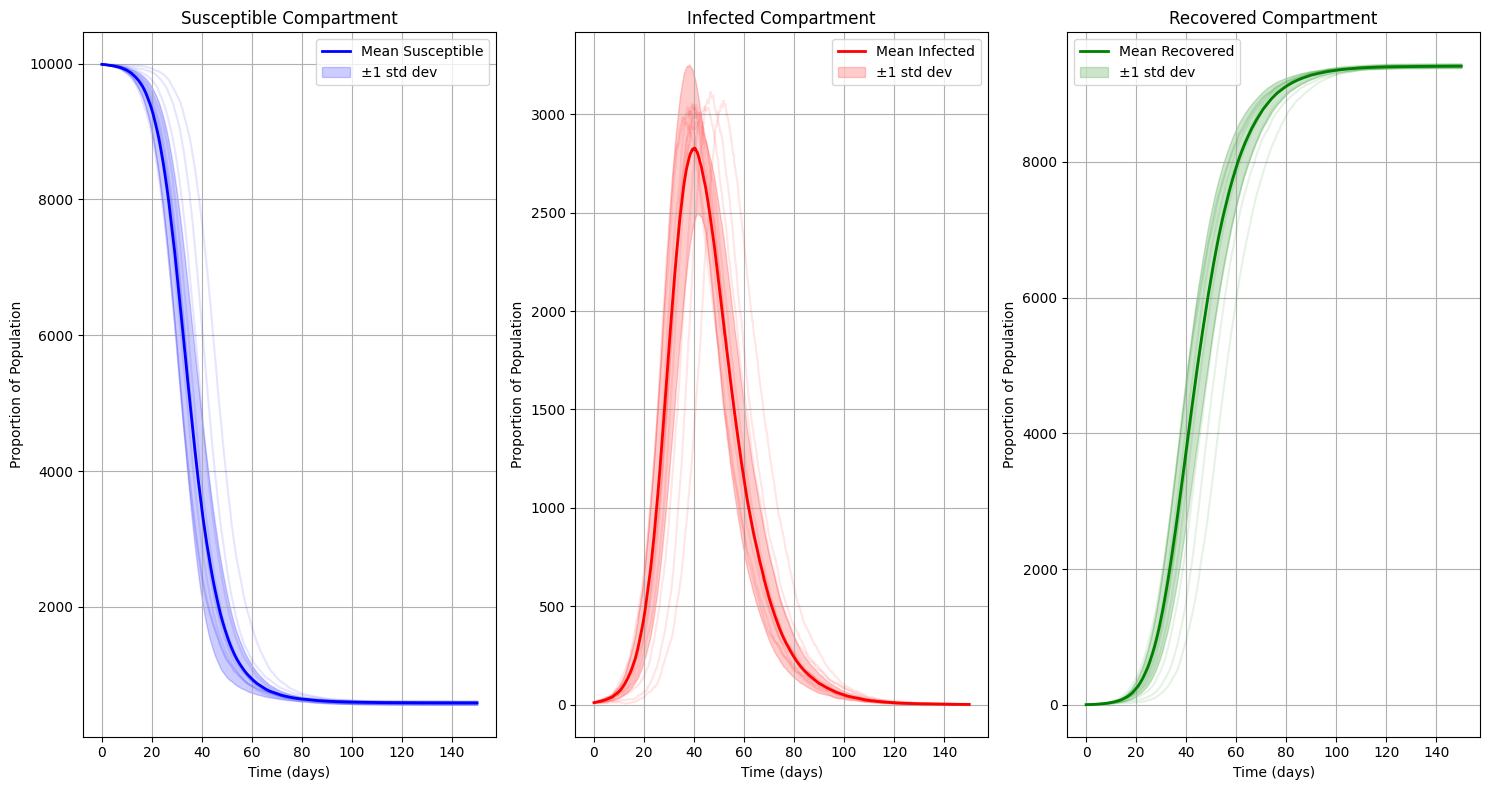

Preparing data for machine learning...
Training neural network SIR predictor...
Epoch 100/1000, Loss: 0.000724
Epoch 200/1000, Loss: 0.000053
Epoch 300/1000, Loss: 0.000016
Epoch 400/1000, Loss: 0.000007
Epoch 500/1000, Loss: 0.000004
Epoch 600/1000, Loss: 0.000003
Epoch 700/1000, Loss: 0.000003
Epoch 800/1000, Loss: 0.000002
Epoch 900/1000, Loss: 0.000002
Epoch 1000/1000, Loss: 0.000001
Neural Network Test MSE: 0.000006


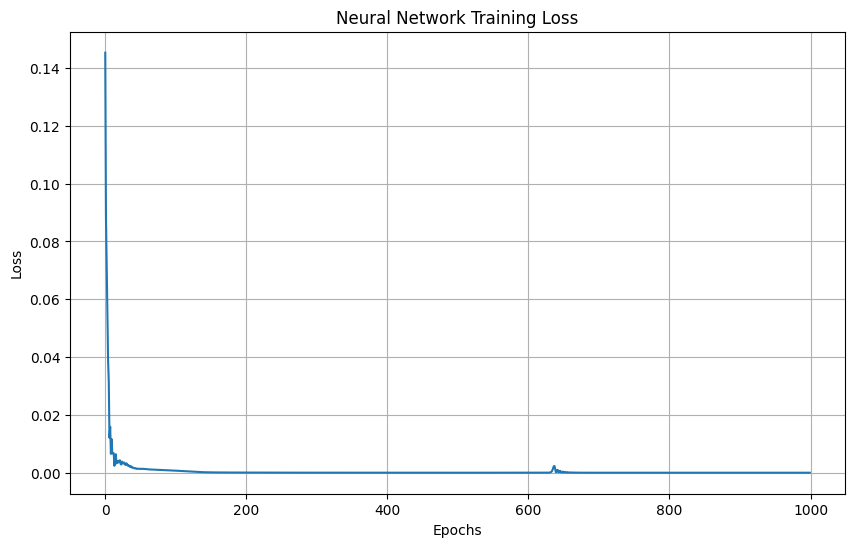

Training physics-informed neural network...
Epoch 200/2000, Data Loss: 0.064987, Physics Loss: 0.137112
Epoch 400/2000, Data Loss: 0.064437, Physics Loss: 0.139334
Epoch 600/2000, Data Loss: 0.064420, Physics Loss: 0.139391
Epoch 800/2000, Data Loss: 0.064415, Physics Loss: 0.139411
Epoch 1000/2000, Data Loss: 0.064413, Physics Loss: 0.139417
Epoch 1200/2000, Data Loss: 0.064412, Physics Loss: 0.139420
Epoch 1400/2000, Data Loss: 0.064410, Physics Loss: 0.139421
Epoch 1600/2000, Data Loss: 0.064408, Physics Loss: 0.139422
Epoch 1800/2000, Data Loss: 0.064406, Physics Loss: 0.139424
Epoch 2000/2000, Data Loss: 0.064401, Physics Loss: 0.139433


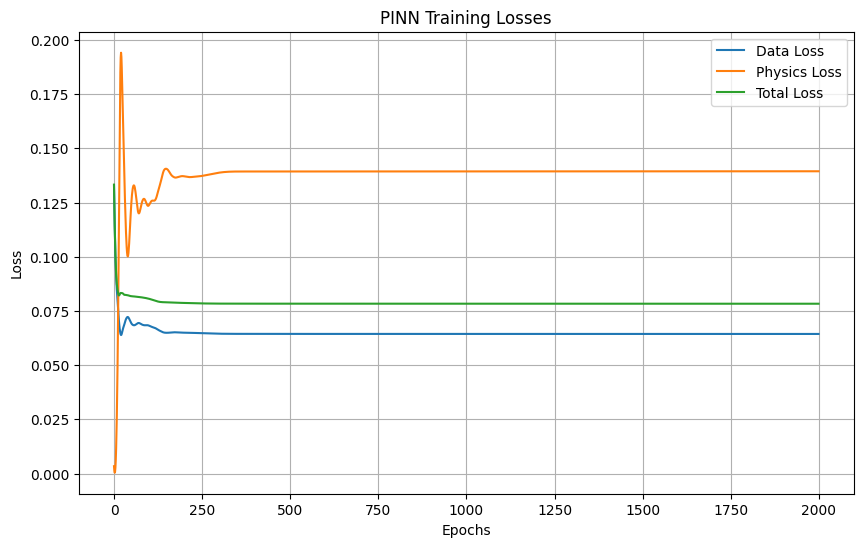

Performing symbolic regression...
Symbolic Expressions:
S(t) = -6.6658047312429e-7*t**3 + 0.000256775930765586*t**2 - 0.0313459634282324*t + 1.25971089526119
I(t) = 8.41820829962717e-7*t**3 - 0.000204692939697058*t**2 + 0.0125978771841923*t - 0.0572973086840753
R(t) = -1.75240356836692e-7*t**3 - 5.2082991068528e-5*t**2 + 0.0187480862440401*t - 0.202413586578596
Comparing all models...
Model Comparison Results:
            Model         S         I             R   Overall
3   Deterministic  0.000000  0.000000  0.000000e+00  0.000000
0  Neural Network  0.000003  0.000002  7.057049e-07  0.000002
2        Symbolic  0.007233  0.002685  6.977439e-03  0.005632
1            PINN  0.080320  0.007323  8.686265e-02  0.058168


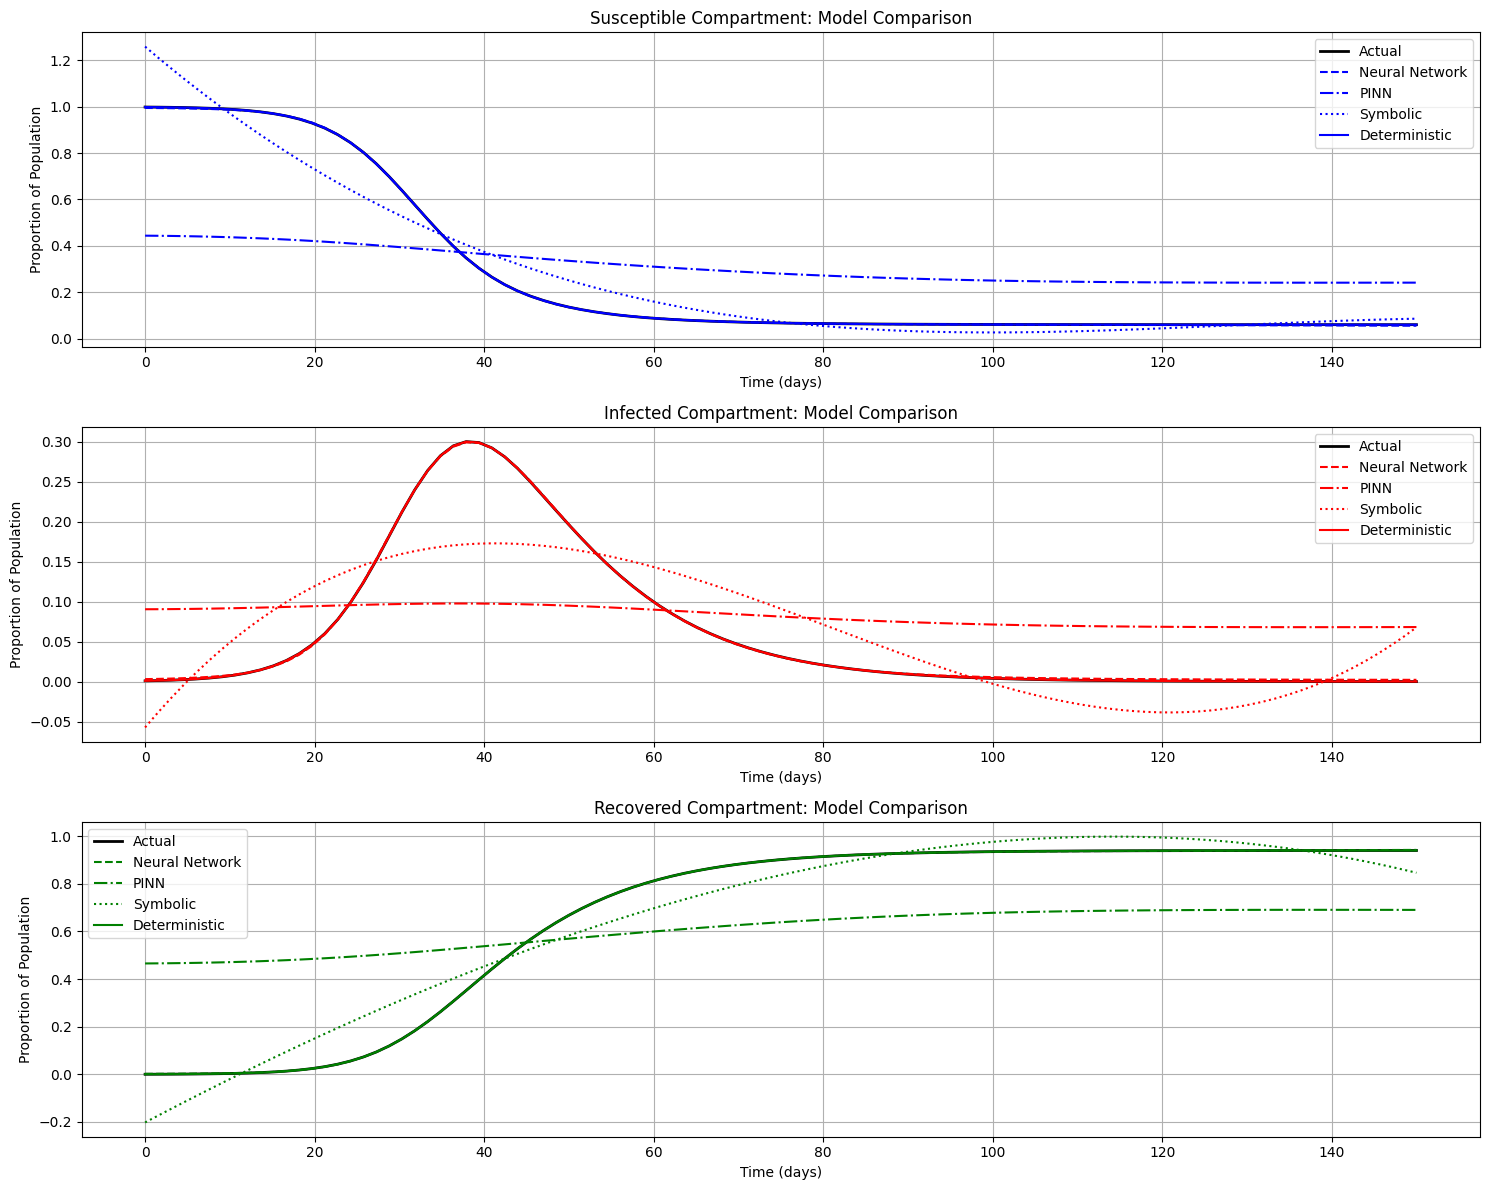

Quantifying uncertainty...


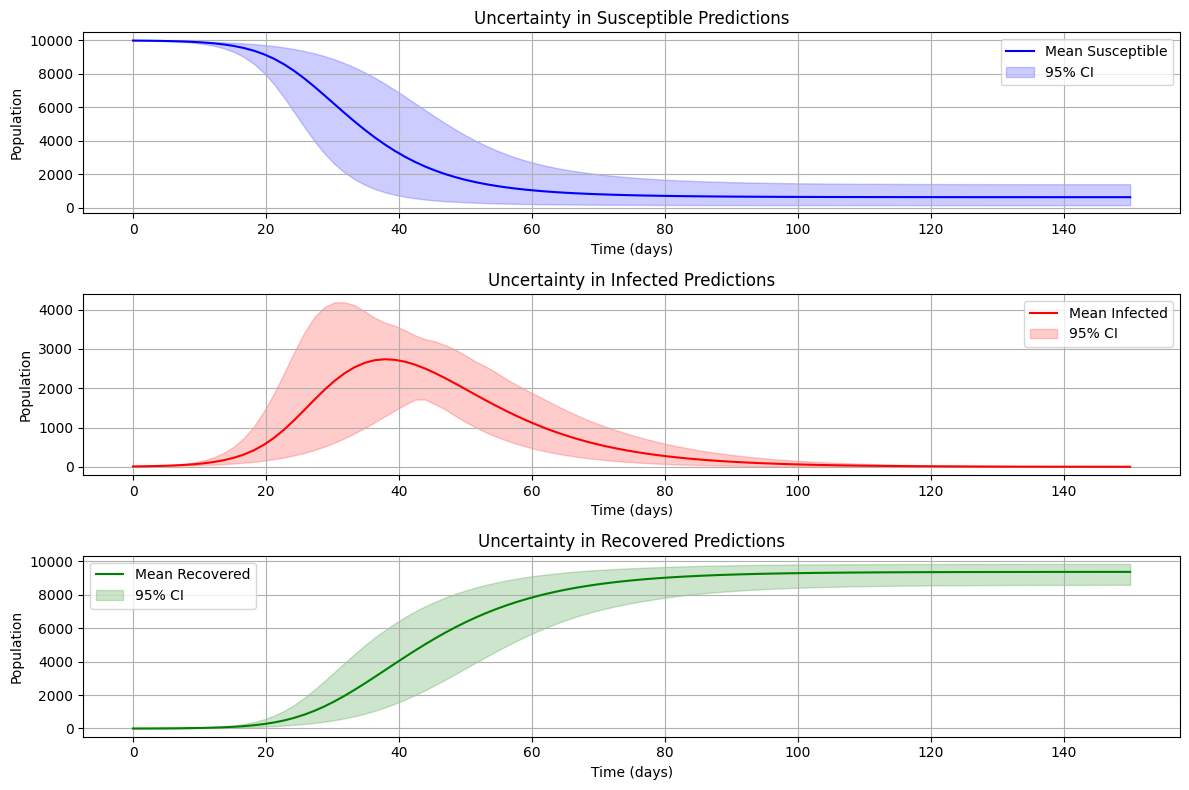

All analyses complete!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import sympy as sp
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Part 1: SIR Model Implementation with both Deterministic and Stochastic versions
class SIRModel:
    def __init__(self, beta, gamma, population_size):
        """
        Initialize the SIR model parameters.

        Args:
            beta: The infection rate parameter
            gamma: The recovery rate parameter
            population_size: Total population size
        """
        self.beta = beta
        self.gamma = gamma
        self.population_size = population_size

    def sir_derivatives(self, t, y):
        """
        Define the system of differential equations for the deterministic SIR model.

        Args:
            t: Time point
            y: Current state [S, I, R]

        Returns:
            Derivatives [dS/dt, dI/dt, dR/dt]
        """
        S, I, R = y
        N = self.population_size

        dSdt = -self.beta * S * I / N
        dIdt = self.beta * S * I / N - self.gamma * I
        dRdt = self.gamma * I

        return [dSdt, dIdt, dRdt]

    def simulate_deterministic(self, initial_conditions, t_span, t_points=100):
        """
        Simulate the deterministic SIR model.

        Args:
            initial_conditions: Initial values for [S, I, R]
            t_span: Time span for simulation [t_start, t_end]
            t_points: Number of time points to evaluate

        Returns:
            Time points and corresponding SIR values
        """
        t_eval = np.linspace(t_span[0], t_span[1], t_points)
        solution = solve_ivp(
            self.sir_derivatives,
            t_span,
            initial_conditions,
            t_eval=t_eval,
            method='RK45'
        )

        return solution.t, solution.y

    def simulate_stochastic(self, initial_conditions, t_span, n_simulations=10, dt=0.1):
        """
        Simulate the stochastic SIR model using the Gillespie algorithm.

        Args:
            initial_conditions: Initial values for [S, I, R]
            t_span: Time span for simulation [t_start, t_end]
            n_simulations: Number of stochastic simulations to run
            dt: Time step for output

        Returns:
            Time points and array of simulation results
        """
        t_max = t_span[1]
        time_points = np.arange(0, t_max + dt, dt)
        n_points = len(time_points)

        # Initialize arrays to store results from all simulations
        all_S = np.zeros((n_simulations, n_points))
        all_I = np.zeros((n_simulations, n_points))
        all_R = np.zeros((n_simulations, n_points))

        for sim in range(n_simulations):
            # Initialize state
            S, I, R = initial_conditions
            S, I, R = int(S), int(I), int(R)  # Ensure integer counts for individuals

            # Initialize time and result arrays for this simulation
            t = 0
            S_trajectory = [S]
            I_trajectory = [I]
            R_trajectory = [R]
            t_trajectory = [0]

            # Run the Gillespie algorithm
            while t < t_max and I > 0:
                # Calculate rates of all possible events
                infection_rate = self.beta * S * I / self.population_size
                recovery_rate = self.gamma * I
                total_rate = infection_rate + recovery_rate

                # If no events possible, break
                if total_rate == 0:
                    break

                # Time until next event (exponentially distributed)
                tau = np.random.exponential(1/total_rate)
                t += tau

                # Determine which event occurs
                if np.random.random() < infection_rate / total_rate:
                    # Infection event
                    S -= 1
                    I += 1
                else:
                    # Recovery event
                    I -= 1
                    R += 1

                # Record the new state
                S_trajectory.append(S)
                I_trajectory.append(I)
                R_trajectory.append(R)
                t_trajectory.append(t)

            # Interpolate to get values at standard time points
            all_S[sim] = np.interp(time_points, t_trajectory, S_trajectory)
            all_I[sim] = np.interp(time_points, t_trajectory, I_trajectory)
            all_R[sim] = np.interp(time_points, t_trajectory, R_trajectory)

        # Calculate mean trajectories
        mean_S = np.mean(all_S, axis=0)
        mean_I = np.mean(all_I, axis=0)
        mean_R = np.mean(all_R, axis=0)

        # Calculate standard deviations
        std_S = np.std(all_S, axis=0)
        std_I = np.std(all_I, axis=0)
        std_R = np.std(all_R, axis=0)

        return time_points, np.array([mean_S, mean_I, mean_R]), np.array([std_S, std_I, std_R]), (all_S, all_I, all_R)

# Part 2: Enhanced Neural Network to Predict All SIR Compartments
class SIRPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=3):
        """
        Neural Network for predicting all SIR compartments.

        Args:
            input_size: Number of input features (time)
            hidden_size: Size of hidden layer
            output_size: Size of output (S, I, R proportions)
        """
        super(SIRPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)  # Ensure outputs sum to 1
        )

    def forward(self, x):
        """Forward pass through the network."""
        return self.network(x)

# Part 3: Physics-Informed Neural Network (PINN) for SIR Model
class SIRPINN(nn.Module):
    def __init__(self, beta, gamma, hidden_size=64):
        """
        Physics-Informed Neural Network for SIR model.

        Args:
            beta: Infection rate parameter
            gamma: Recovery rate parameter
            hidden_size: Size of hidden layers
        """
        super(SIRPINN, self).__init__()
        self.beta = beta
        self.gamma = gamma

        # Neural network to approximate S(t), I(t), R(t)
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 3),
            nn.Softmax(dim=1)  # Ensure outputs sum to 1
        )

    def forward(self, t):
        """
        Forward pass to predict S, I, R values at time t.

        Args:
            t: Time points tensor of shape [batch_size, 1]

        Returns:
            Predicted S, I, R values
        """
        return self.net(t)

    def compute_physics_loss(self, t):
        """
        Compute physics-informed loss based on the SIR differential equations.

        Args:
            t: Time points tensor requiring gradient

        Returns:
            Loss based on the physics constraints
        """
        t.requires_grad_(True)

        # Forward pass to get S, I, R
        sir_pred = self.forward(t)
        S, I, R = sir_pred[:, 0:1], sir_pred[:, 1:2], sir_pred[:, 2:3]

        # Compute gradients using auto-differentiation
        S_t = torch.autograd.grad(
            S, t, grad_outputs=torch.ones_like(S),
            create_graph=True, retain_graph=True
        )[0]

        I_t = torch.autograd.grad(
            I, t, grad_outputs=torch.ones_like(I),
            create_graph=True, retain_graph=True
        )[0]

        R_t = torch.autograd.grad(
            R, t, grad_outputs=torch.ones_like(R),
            create_graph=True, retain_graph=True
        )[0]

        # SIR model equations
        dSdt = -self.beta * S * I
        dIdt = self.beta * S * I - self.gamma * I
        dRdt = self.gamma * I

        # Physics-informed loss: MSE between computed gradients and SIR model equations
        loss_S = nn.MSELoss()(S_t, dSdt)
        loss_I = nn.MSELoss()(I_t, dIdt)
        loss_R = nn.MSELoss()(R_t, dRdt)

        return loss_S + loss_I + loss_R

# Part 4: Symbolic Regression for SIR Approximation
class SymbolicSIRApproximator:
    def __init__(self, degree=3):
        """
        Approximate SIR functions symbolically using polynomial regression.

        Args:
            degree: Degree of polynomial to use for approximation
        """
        self.degree = degree
        self.poly_features = PolynomialFeatures(degree=degree)
        self.S_model = LinearRegression()
        self.I_model = LinearRegression()
        self.R_model = LinearRegression()
        self.t_sym = sp.Symbol('t')

    def fit(self, t, sir_data):
        """
        Fit polynomial regression models to SIR data.

        Args:
            t: Time points
            sir_data: SIR model data [S, I, R]

        Returns:
            Symbolic expressions for S(t), I(t), R(t)
        """
        # Normalize data
        N = np.sum(sir_data[:, 0])
        S_norm = sir_data[0, :] / N
        I_norm = sir_data[1, :] / N
        R_norm = sir_data[2, :] / N

        # Reshape time for polynomial features
        t_reshaped = t.reshape(-1, 1)
        t_poly = self.poly_features.fit_transform(t_reshaped)

        # Fit models
        self.S_model.fit(t_poly, S_norm)
        self.I_model.fit(t_poly, I_norm)
        self.R_model.fit(t_poly, R_norm)

        # Create symbolic expressions
        self.S_expr = self._create_symbolic_expression(self.S_model.coef_, self.S_model.intercept_)
        self.I_expr = self._create_symbolic_expression(self.I_model.coef_, self.I_model.intercept_)
        self.R_expr = self._create_symbolic_expression(self.R_model.coef_, self.R_model.intercept_)

        return self.S_expr, self.I_expr, self.R_expr

    def _create_symbolic_expression(self, coefficients, intercept):
        """
        Create a symbolic expression from polynomial coefficients.

        Args:
            coefficients: Coefficients from LinearRegression
            intercept: Intercept from LinearRegression

        Returns:
            SymPy expression
        """
        expr = intercept
        t = self.t_sym

        # Skip the first coefficient (corresponds to the constant term)
        for i, coef in enumerate(coefficients[1:], 1):
            if i == 1:
                term = coef * t
            else:
                # Determine which powers of t this coefficient corresponds to
                powers = self.poly_features.powers_[i]
                term_expr = coef
                for j, power in enumerate(powers):
                    if power > 0:
                        term_expr *= t ** power
                term = term_expr
            expr += term

        return sp.simplify(expr)

    def predict(self, t_new):
        """
        Predict SIR values using fitted models.

        Args:
            t_new: New time points

        Returns:
            Predicted S, I, R values
        """
        t_reshaped = t_new.reshape(-1, 1)
        t_poly = self.poly_features.transform(t_reshaped)

        S_pred = self.S_model.predict(t_poly)
        I_pred = self.I_model.predict(t_poly)
        R_pred = self.R_model.predict(t_poly)

        return np.array([S_pred, I_pred, R_pred])

    def get_symbolic_expressions(self):
        """
        Get the symbolic expressions as strings.

        Returns:
            String representations of S(t), I(t), R(t)
        """
        return str(self.S_expr), str(self.I_expr), str(self.R_expr)

# Part 5: Data Preparation
def prepare_data(t, sir_data, population_size, train_ratio=0.8):
    """
    Prepare data for neural network training.

    Args:
        t: Time points
        sir_data: SIR model data [S, I, R]
        population_size: Total population size
        train_ratio: Ratio of data to use for training

    Returns:
        Training and testing data tensors
    """
    # Normalize data
    S_norm = sir_data[0, :] / population_size
    I_norm = sir_data[1, :] / population_size
    R_norm = sir_data[2, :] / population_size
    t_norm = t / np.max(t)

    # Prepare features (time) and targets (S, I, R)
    X = t_norm.reshape(-1, 1)
    y = np.column_stack((S_norm, I_norm, R_norm))

    # Convert to tensors with explicit dtype
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Split into training and testing sets
    train_size = int(train_ratio * len(X))
    X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

    return X_train, y_train, X_test, y_test

# Part 6: Hyperparameter Tuning and Model Selection
class HyperparameterTuner:
    def __init__(self, X_train, y_train, X_val, y_val):
        """
        Tune hyperparameters for SIR prediction models.

        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features
            y_val: Validation targets
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.best_model = None
        self.best_loss = float('inf')
        self.best_params = {}

    def tune_sir_predictor(self, hidden_sizes=[32, 64, 128], learning_rates=[0.01, 0.001, 0.0001], epochs=500):
        """
        Tune hyperparameters for SIR Predictor neural network.

        Args:
            hidden_sizes: List of hidden layer sizes to try
            learning_rates: List of learning rates to try
            epochs: Number of training epochs

        Returns:
            Best model and its hyperparameters
        """
        print("Tuning SIR Predictor hyperparameters...")

        for hidden_size in hidden_sizes:
            for learning_rate in learning_rates:
                print(f"  Testing hidden_size={hidden_size}, learning_rate={learning_rate}")

                # Create model with current hyperparameters
                model = SIRPredictor(hidden_size=hidden_size)

                # Train model
                model, _ = train_sir_predictor(model, self.X_train, self.y_train,
                                              epochs=epochs, learning_rate=learning_rate, verbose=False)

                # Evaluate on validation set
                val_loss = evaluate_model(model, self.X_val, self.y_val)
                print(f"  Validation loss: {val_loss:.6f}")

                # Update best model if this one is better
                if val_loss < self.best_loss:
                    self.best_loss = val_loss
                    self.best_model = model
                    self.best_params = {
                        'hidden_size': hidden_size,
                        'learning_rate': learning_rate
                    }

        print(f"Best hyperparameters: {self.best_params}")
        print(f"Best validation loss: {self.best_loss:.6f}")

        return self.best_model, self.best_params

# Part 7: Training and Evaluation
def train_sir_predictor(model, X_train, y_train, epochs=1000, learning_rate=0.01, verbose=True):
    """
    Train the SIR predictor neural network.

    Args:
        model: The neural network model
        X_train: Training features
        y_train: Training targets
        epochs: Number of training epochs
        learning_rate: Learning rate for optimization
        verbose: Whether to print progress

    Returns:
        Trained model and training losses
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Print progress
        if verbose and (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

    return model, losses

def train_pinn(model, t_train, y_train, epochs=2000, learning_rate=0.001, physics_weight=0.1, verbose=True):
    """
    Train the Physics-Informed Neural Network.

    Args:
        model: The PINN model
        t_train: Training time points
        y_train: Training SIR values
        epochs: Number of training epochs
        learning_rate: Learning rate for optimization
        physics_weight: Weight for physics loss component
        verbose: Whether to print progress

    Returns:
        Trained model and training losses
    """
    data_criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    data_losses = []
    physics_losses = []
    total_losses = []

    # Create collocation points for physics-informed training
    t_collocation = torch.linspace(0, 1, 100, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    for epoch in range(epochs):
        # Data loss
        sir_pred = model(t_train)
        data_loss = data_criterion(sir_pred, y_train)

        # Physics loss
        physics_loss = model.compute_physics_loss(t_collocation)

        # Total loss
        total_loss = data_loss + physics_weight * physics_loss

        # Backward pass and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        data_losses.append(data_loss.item())
        physics_losses.append(physics_loss.item())
        total_losses.append(total_loss.item())

        # Print progress
        if verbose and (epoch+1) % 200 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}')

    return model, {'data': data_losses, 'physics': physics_losses, 'total': total_losses}

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model.

    Args:
        model: Trained neural network model
        X_test: Test features
        y_test: Test targets

    Returns:
        Mean squared error on test data
    """
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test).item()
    return mse

# Part 8: Visualization Functions
def plot_sir_simulation(t, sir_data, population_size, title="SIR Model Simulation", filename="sir_simulation.png"):
    """
    Plot the SIR model simulation results.

    Args:
        t: Time points
        sir_data: SIR model data [S, I, R]
        population_size: Total population size
        title: Plot title
        filename: Filename for saving
    """
    plt.figure(figsize=(10, 6))
    plt.plot(t, sir_data[0, :], 'b-', label='Susceptible')
    plt.plot(t, sir_data[1, :], 'r-', label='Infected')
    plt.plot(t, sir_data[2, :], 'g-', label='Recovered')
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_stochastic_sir_simulation(t, mean_sir_data, std_sir_data, all_simulations=None, population_size=None):
    """
    Plot the stochastic SIR model simulation results.

    Args:
        t: Time points
        mean_sir_data: Mean SIR data [mean_S, mean_I, mean_R]
        std_sir_data: Standard deviation of SIR data [std_S, std_I, std_R]
        all_simulations: Optional tuple of (all_S, all_I, all_R) containing all simulation runs
        population_size: Total population size (for normalization)
    """
    compartment_names = ['Susceptible', 'Infected', 'Recovered']
    colors = ['b', 'r', 'g']

    plt.figure(figsize=(15, 8))

    for i, (name, color) in enumerate(zip(compartment_names, colors)):
        plt.subplot(1, 3, i+1)

        # Plot mean trajectory
        mean_traj = mean_sir_data[i]
        std_traj = std_sir_data[i]

        plt.plot(t, mean_traj, f'{color}-', linewidth=2, label=f'Mean {name}')

        # Plot confidence interval
        plt.fill_between(t, mean_traj - std_traj, mean_traj + std_traj,
                        color=color, alpha=0.2, label=f'±1 std dev')

        # Plot individual trajectories (if provided)
        if all_simulations is not None:
            n_sims_to_plot = min(10, all_simulations[0].shape[0])  # Plot up to 10 simulations
            for j in range(n_sims_to_plot):
                plt.plot(t, all_simulations[i][j], f'{color}-', alpha=0.1)

        plt.xlabel('Time (days)')
        plt.ylabel('Population' if population_size is None else 'Proportion of Population')
        plt.title(f'{name} Compartment')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('stochastic_sir_simulation.png')
    plt.show()

def plot_prediction_comparison(t, actual, predicted, train_size, compartment_names):
    """
    Plot comparison between actual and predicted SIR values.

    Args:
        t: Time points
        actual: Actual SIR data [S, I, R]
        predicted: Predicted SIR data [S, I, R]
        train_size: Size of training data (for visualization)
        compartment_names: Names of compartments for labels
    """
    colors = ['b', 'r', 'g']
    plt.figure(figsize=(15, 8))

    for i, (name, color) in enumerate(zip(compartment_names, colors)):
        plt.subplot(1, 3, i+1)
        plt.plot(t, actual[i], f'{color}-', label=f'Actual {name}')
        plt.plot(t, predicted[i], f'{color}--', label=f'Predicted {name}')
        plt.axvline(x=t[train_size], color='k', linestyle='--',
                   label='Train-Test Split')
        plt.xlabel('Time (days)')
        plt.ylabel('Proportion of Population')
        plt.title(f'Actual vs Predicted {name}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('prediction_comparison.png')
    plt.show()

def plot_symbolic_comparison(t, sir_data, symbolic_approximator, population_size):
    """
    Plot comparison between actual and symbolically approximated SIR values.

    Args:
        t: Time points
        sir_data: Actual SIR data [S, I, R]
        symbolic_approximator: Fitted SymbolicSIRApproximator
        population_size: Total population size
    """
    symbolic_pred = symbolic_approximator.predict(t)

    plt.figure(figsize=(15, 8))
    compartment_names = ['Susceptible', 'Infected', 'Recovered']
    colors = ['b', 'r', 'g']

    for i, (name, color) in enumerate(zip(compartment_names, colors)):
        plt.subplot(1, 3, i+1)
        plt.plot(t, sir_data[i, :] / population_size, f'{color}-', label=f'Actual {name}')
        plt.plot(t, symbolic_pred[i], f'{color}--', label=f'Symbolic {name}')
        plt.xlabel('Time (days)')
        plt.ylabel('Proportion of Population')
        plt.title(f'Actual vs Symbolic {name}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('symbolic_comparison.png')
    plt.show()

def plot_pinn_comparison(t, sir_data, pinn_model, population_size):
    """
    Plot comparison between actual and PINN-predicted SIR values.

    Args:
        t: Time points
        sir_data: Actual SIR data [S, I, R]
        pinn_model: Trained PINN model
        population_size: Total population size
    """
    t_tensor = torch.tensor(t / np.max(t)).reshape(-1, 1)
    pinn_model.eval()

    with torch.no_grad():
        pinn_pred = pinn_model(t_tensor).numpy().T

    plt.figure(figsize=(15, 8))
    compartment_names = ['Susceptible', 'Infected', 'Recovered']
    colors = ['b', 'r', 'g']

    for i, (name, color) in enumerate(zip(compartment_names, colors)):
        plt.subplot(1, 3, i+1)
        plt.plot(t, sir_data[i, :] / population_size, f'{color}-', label=f'Actual {name}')
        plt.plot(t, pinn_pred[i], f'{color}--', label=f'PINN {name}')
        plt.xlabel('Time (days)')
        plt.ylabel('Proportion of Population')
        plt.title(f'Actual vs PINN {name}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('pinn_comparison.png')
    plt.show()

def plot_training_losses(losses, title, filename):
    """
    Plot training losses.

    Args:
        losses: Dictionary or list of loss values
        title: Plot title
        filename: Filename for saving
    """
    plt.figure(figsize=(10, 6))

    if isinstance(losses, dict):
        for loss_type, values in losses.items():
            plt.plot(values, label=f'{loss_type.capitalize()} Loss')
        plt.legend()
    else:
        plt.plot(losses)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Completing the last visualization function that was cut off
def plot_model_comparison(t, sir_data, models_dict, population_size):
    """
    Plot comparison between actual data and predictions from multiple models.

    Args:
        t: Time points
        sir_data: Actual SIR data [S, I, R]
        models_dict: Dictionary of model predictions {model_name: predictions}
        population_size: Total population size
    """
    compartment_names = ['Susceptible', 'Infected', 'Recovered']
    colors = ['b', 'r', 'g']
    model_styles = {
        'Neural Network': '--',
        'PINN': '-.',
        'Symbolic': ':',
        'Deterministic': '-',
        'Stochastic Mean': '-'
    }

    plt.figure(figsize=(15, 12))

    for i, (name, color) in enumerate(zip(compartment_names, colors)):
        plt.subplot(3, 1, i+1)

        # Plot actual data
        plt.plot(t, sir_data[i, :] / population_size, 'k-', linewidth=2, label='Actual')

        # Plot predictions from different models
        for model_name, predictions in models_dict.items():
            if model_name in model_styles:
                style = model_styles[model_name]
                plt.plot(t, predictions[i], color=color, linestyle=style, label=f'{model_name}')

        plt.xlabel('Time (days)')
        plt.ylabel('Proportion of Population')
        plt.title(f'{name} Compartment: Model Comparison')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# Part 9: Model Evaluation and Comparison Framework
class ModelEvaluator:
    def __init__(self, t, sir_data, population_size):
        """
        Framework for comparing different SIR prediction models.

        Args:
            t: Time points
            sir_data: SIR model data [S, I, R]
            population_size: Total population size
        """
        self.t = t
        self.sir_data = sir_data
        self.population_size = population_size
        self.normalized_sir = sir_data / population_size
        self.models = {}
        self.predictions = {}
        self.metrics = {}

    def add_model(self, name, model, prediction_function=None):
        """
        Add a model to the evaluation framework.

        Args:
            name: Model name
            model: The model object
            prediction_function: Function to generate predictions (if None, uses default)
        """
        self.models[name] = {
            'model': model,
            'prediction_function': prediction_function
        }

    def generate_predictions(self):
        """
        Generate predictions from all added models.

        Returns:
            Dictionary of model predictions
        """
        for name, model_info in self.models.items():
            model = model_info['model']
            pred_func = model_info['prediction_function']

            if pred_func is None:
                # Default prediction functions based on model type
                if isinstance(model, SIRPredictor) or isinstance(model, SIRPINN):
                    # Neural network models
                    t_tensor = torch.tensor(self.t / np.max(self.t), dtype=torch.float32).reshape(-1, 1)
                    model.eval()
                    with torch.no_grad():
                        pred = model(t_tensor).numpy().T
                    self.predictions[name] = pred
                elif isinstance(model, SymbolicSIRApproximator):
                    # Symbolic model
                    self.predictions[name] = model.predict(self.t)
                elif isinstance(model, SIRModel):
                    # Deterministic SIR model
                    _, pred = model.simulate_deterministic(
                        [self.sir_data[0, 0], self.sir_data[1, 0], self.sir_data[2, 0]],
                        [0, self.t[-1]],
                        t_points=len(self.t)
                    )
                    self.predictions[name] = pred / self.population_size
            else:
                # Custom prediction function
                self.predictions[name] = pred_func(model, self.t)

        return self.predictions

    def calculate_metrics(self):
        """
        Calculate evaluation metrics for all models.

        Returns:
            Dictionary of metrics for each model
        """
        if not self.predictions:
            self.generate_predictions()

        for name, pred in self.predictions.items():
            # Calculate MSE for each compartment
            mse_s = np.mean((self.normalized_sir[0] - pred[0]) ** 2)
            mse_i = np.mean((self.normalized_sir[1] - pred[1]) ** 2)
            mse_r = np.mean((self.normalized_sir[2] - pred[2]) ** 2)

            # Calculate RMSE for each compartment
            rmse_s = np.sqrt(mse_s)
            rmse_i = np.sqrt(mse_i)
            rmse_r = np.sqrt(mse_r)

            # Calculate MAE for each compartment
            mae_s = np.mean(np.abs(self.normalized_sir[0] - pred[0]))
            mae_i = np.mean(np.abs(self.normalized_sir[1] - pred[1]))
            mae_r = np.mean(np.abs(self.normalized_sir[2] - pred[2]))

            # Store metrics
            self.metrics[name] = {
                'MSE': {'S': mse_s, 'I': mse_i, 'R': mse_r, 'Overall': (mse_s + mse_i + mse_r) / 3},
                'RMSE': {'S': rmse_s, 'I': rmse_i, 'R': rmse_r, 'Overall': (rmse_s + rmse_i + rmse_r) / 3},
                'MAE': {'S': mae_s, 'I': mae_i, 'R': mae_r, 'Overall': (mae_s + mae_i + mae_r) / 3}
            }

        return self.metrics

    def compare_models(self, metric='MSE'):
        """
        Compare models based on a specific metric.

        Args:
            metric: Metric to use for comparison ('MSE', 'RMSE', or 'MAE')

        Returns:
            DataFrame with comparison results
        """
        if not self.metrics:
            self.calculate_metrics()

        # Create comparison DataFrame
        comparison = {
            'Model': [],
            'S': [],
            'I': [],
            'R': [],
            'Overall': []
        }

        for name, metrics in self.metrics.items():
            comparison['Model'].append(name)
            comparison['S'].append(metrics[metric]['S'])
            comparison['I'].append(metrics[metric]['I'])
            comparison['R'].append(metrics[metric]['R'])
            comparison['Overall'].append(metrics[metric]['Overall'])

        df = pd.DataFrame(comparison)
        df = df.sort_values('Overall')

        return df

    def plot_model_comparison(self):
        """
        Plot comparison of all models.
        """
        if not self.predictions:
            self.generate_predictions()

        plot_model_comparison(self.t, self.sir_data, self.predictions, self.population_size)

    def plot_residuals(self, model_name):
        """
        Plot residuals for a specific model.

        Args:
            model_name: Name of the model to plot residuals for
        """
        if not self.predictions:
            self.generate_predictions()

        pred = self.predictions[model_name]

        plt.figure(figsize=(15, 8))
        compartment_names = ['Susceptible', 'Infected', 'Recovered']
        colors = ['b', 'r', 'g']

        for i, (name, color) in enumerate(zip(compartment_names, colors)):
            plt.subplot(1, 3, i+1)
            residuals = self.normalized_sir[i] - pred[i]
            plt.plot(self.t, residuals, f'{color}-')
            plt.axhline(y=0, color='k', linestyle='--')
            plt.xlabel('Time (days)')
            plt.ylabel('Residual')
            plt.title(f'{name} Residuals: {model_name}')
            plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'residuals_{model_name}.png')
        plt.show()

# Part 10: Real-world Data Integration
class RealDataIntegrator:
    def __init__(self, data_path):
        """
        Load and process real-world epidemic data.

        Args:
            data_path: Path to the CSV data file
        """
        self.data = pd.read_csv(data_path)
        self.processed_data = None
        self.population_size = None

    def process_data(self, date_column, cases_column, recoveries_column=None, deaths_column=None,
                     population_size=None, initial_susceptible=None, smooth_window=7):
        """
        Process the epidemic data into SIR format.

        Args:
            date_column: Column name for dates
            cases_column: Column name for cumulative cases
            recoveries_column: Column name for cumulative recoveries (optional)
            deaths_column: Column name for cumulative deaths (optional)
            population_size: Total population size (if None, will be estimated)
            initial_susceptible: Initial susceptible population (if None, will be set to population_size)
            smooth_window: Window size for smoothing the data

        Returns:
            Time points, SIR data, and population size
        """
        # Convert date to datetime and sort
        self.data[date_column] = pd.to_datetime(self.data[date_column])
        self.data = self.data.sort_values(date_column)

        # Calculate days from the start
        start_date = self.data[date_column].min()
        self.data['days'] = (self.data[date_column] - start_date).dt.days

        # Apply smoothing to cases
        self.data[f'{cases_column}_smooth'] = self.data[cases_column].rolling(
            window=smooth_window, min_periods=1, center=True).mean()

        # Calculate active cases
        if recoveries_column is not None and deaths_column is not None:
            # Apply smoothing to recoveries and deaths
            self.data[f'{recoveries_column}_smooth'] = self.data[recoveries_column].rolling(
                window=smooth_window, min_periods=1, center=True).mean()
            self.data[f'{deaths_column}_smooth'] = self.data[deaths_column].rolling(
                window=smooth_window, min_periods=1, center=True).mean()

            # Active cases = Total cases - Recoveries - Deaths
            self.data['active_cases'] = (
                self.data[f'{cases_column}_smooth'] -
                self.data[f'{recoveries_column}_smooth'] -
                self.data[f'{deaths_column}_smooth']
            )

            # Recovered + Deaths
            self.data['recovered'] = self.data[f'{recoveries_column}_smooth'] + self.data[f'{deaths_column}_smooth']
        else:
            # Estimate active cases using a simple SIR assumption
            # Assume infectious period of 14 days, so recovery rate is 1/14
            gamma = 1/14

            # Estimate daily new cases by differencing
            self.data['new_cases'] = self.data[f'{cases_column}_smooth'].diff().fillna(0)

            # Estimate recoveries using the recovery rate
            self.data['estimated_recoveries'] = self.data['new_cases'].shift(14).fillna(0)
            self.data['recovered'] = self.data['estimated_recoveries'].cumsum()

            # Active cases = Total cases - Estimated recoveries
            self.data['active_cases'] = self.data[f'{cases_column}_smooth'] - self.data['recovered']

        # Set or estimate population size
        if population_size is None:
            # Estimate as maximum cases + a margin
            self.population_size = int(self.data[f'{cases_column}_smooth'].max() * 2)
        else:
            self.population_size = population_size

        # Set initial susceptible population
        if initial_susceptible is None:
            initial_susceptible = self.population_size

        # Calculate SIR values
        t = self.data['days'].values
        S = initial_susceptible - self.data[f'{cases_column}_smooth'].values
        I = self.data['active_cases'].values
        R = self.data['recovered'].values

        # Ensure non-negative values
        S = np.maximum(S, 0)
        I = np.maximum(I, 0)
        R = np.maximum(R, 0)

        # Store processed data
        self.processed_data = {
            't': t,
            'sir_data': np.array([S, I, R]),
            'population_size': self.population_size
        }

        return t, np.array([S, I, R]), self.population_size

    def estimate_sir_parameters(self):
        """
        Estimate SIR model parameters (beta, gamma) from the data.

        Returns:
            Estimated beta, gamma parameters
        """
        if self.processed_data is None:
            raise ValueError("Data must be processed first using process_data()")

        t = self.processed_data['t']
        S, I, R = self.processed_data['sir_data']
        N = self.population_size

        # Calculate daily changes
        dS = np.diff(S)
        dI = np.diff(I)
        dR = np.diff(R)

        # Truncate arrays to match lengths
        S = S[:-1]
        I = I[:-1]

        # Avoid division by zero
        valid_indices = (S > 0) & (I > 0)
        S = S[valid_indices]
        I = I[valid_indices]
        dS = dS[valid_indices]
        dR = dR[valid_indices]

        if len(S) == 0:
            raise ValueError("Not enough valid data points to estimate parameters")

        # Estimate beta from dS/dt = -beta * S * I / N
        beta_estimates = -dS * N / (S * I)
        beta = np.median(beta_estimates)  # Median is more robust to outliers

        # Estimate gamma from dR/dt = gamma * I
        gamma_estimates = dR / I[valid_indices]
        gamma = np.median(gamma_estimates)

        # Ensure positive values
        beta = max(0.01, beta)
        gamma = max(0.01, gamma)

        return beta, gamma

    def plot_data_fit(self, sir_model=None):
        """
        Plot the processed data and optionally a fitted SIR model.

        Args:
            sir_model: Optional SIR model to plot alongside the data
        """
        if self.processed_data is None:
            raise ValueError("Data must be processed first using process_data()")

        t = self.processed_data['t']
        sir_data = self.processed_data['sir_data']

        plt.figure(figsize=(12, 8))
        compartment_names = ['Susceptible', 'Infected', 'Recovered']
        colors = ['b', 'r', 'g']

        for i, (name, color) in enumerate(zip(compartment_names, colors)):
            plt.plot(t, sir_data[i], f'{color}o', label=f'Data: {name}')

            if sir_model is not None:
                # Simulate SIR model with fitted parameters
                t_sim, sir_sim = sir_model.simulate_deterministic(
                    [sir_data[0, 0], sir_data[1, 0], sir_data[2, 0]],
                    [t[0], t[-1]],
                    t_points=len(t)
                )
                plt.plot(t_sim, sir_sim[i], f'{color}-', label=f'Model: {name}')

        plt.xlabel('Days')
        plt.ylabel('Population')
        plt.title('Real Data and SIR Model Fit')
        plt.legend()
        plt.grid(True)
        plt.savefig('real_data_fit.png')
        plt.show()

# Part 11: Monte Carlo Simulation for Uncertainty Quantification
class UncertaintyQuantifier:
    def __init__(self, sir_model, initial_conditions, t_span, population_size):
        """
        Quantify uncertainty in SIR models using Monte Carlo simulations.

        Args:
            sir_model: Base SIR model
            initial_conditions: Initial SIR values
            t_span: Time span for simulation
            population_size: Total population size
        """
        self.sir_model = sir_model
        self.initial_conditions = initial_conditions
        self.t_span = t_span
        self.population_size = population_size
        self.simulation_results = None

    def run_parameter_variations(self, beta_range=(0.8, 1.2), gamma_range=(0.8, 1.2), n_simulations=100):
        """
        Run Monte Carlo simulations with parameter variations.

        Args:
            beta_range: Range for beta variation as (min_factor, max_factor)
            gamma_range: Range for gamma variation as (min_factor, max_factor)
            n_simulations: Number of simulations to run

        Returns:
            Simulation results
        """
        base_beta = self.sir_model.beta
        base_gamma = self.sir_model.gamma

        # Storage for results
        t_eval = np.linspace(self.t_span[0], self.t_span[1], 100)
        all_results = []
        parameters = []

        for i in range(n_simulations):
            # Generate random parameter variations
            beta_factor = np.random.uniform(beta_range[0], beta_range[1])
            gamma_factor = np.random.uniform(gamma_range[0], gamma_range[1])

            beta = base_beta * beta_factor
            gamma = base_gamma * gamma_factor

            # Create modified model
            modified_model = SIRModel(beta, gamma, self.population_size)

            # Run simulation
            t, sir_data = modified_model.simulate_deterministic(
                self.initial_conditions, self.t_span, t_points=len(t_eval)
            )

            all_results.append(sir_data)
            parameters.append({'beta': beta, 'gamma': gamma})

        # Convert to array
        all_results = np.array(all_results)

        # Calculate statistics
        mean_sir = np.mean(all_results, axis=0)
        std_sir = np.std(all_results, axis=0)
        quantiles = np.quantile(all_results, [0.025, 0.975], axis=0)  # 95% confidence interval

        self.simulation_results = {
            't': t_eval,
            'all_results': all_results,
            'mean_sir': mean_sir,
            'std_sir': std_sir,
            'quantiles': quantiles,
            'parameters': parameters
        }

        return self.simulation_results

    def plot_uncertainty(self):
        """
        Plot uncertainty in SIR predictions.
        """
        if self.simulation_results is None:
            raise ValueError("Must run simulations first using run_parameter_variations()")

        t = self.simulation_results['t']
        mean_sir = self.simulation_results['mean_sir']
        quantiles = self.simulation_results['quantiles']

        plt.figure(figsize=(12, 8))
        compartment_names = ['Susceptible', 'Infected', 'Recovered']
        colors = ['b', 'r', 'g']

        for i, (name, color) in enumerate(zip(compartment_names, colors)):
            plt.subplot(3, 1, i+1)

            # Plot mean
            plt.plot(t, mean_sir[i], f'{color}-', label=f'Mean {name}')

            # Plot confidence intervals
            plt.fill_between(t, quantiles[0, i], quantiles[1, i],
                            color=color, alpha=0.2, label='95% CI')

            plt.xlabel('Time (days)')
            plt.ylabel('Population')
            plt.title(f'Uncertainty in {name} Predictions')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('uncertainty_quantification.png')
        plt.show()

# Part 12: Main function to run all analyses
def main():
    # Set default tensor type to float32
    torch.set_default_dtype(torch.float32)

    # Part 1: Set parameters for SIR model
    beta = 0.3  # Infection rate
    gamma = 0.1  # Recovery rate
    population_size = 10000
    initial_infected = 10
    initial_recovered = 0
    initial_susceptible = population_size - initial_infected - initial_recovered
    initial_conditions = [initial_susceptible, initial_infected, initial_recovered]
    t_span = [0, 150]

    # Create SIR model
    sir_model = SIRModel(beta, gamma, population_size)

    # Simulate deterministic model
    print("Running deterministic SIR simulation...")
    t_det, sir_det = sir_model.simulate_deterministic(initial_conditions, t_span)
    plot_sir_simulation(t_det, sir_det, population_size, "Deterministic SIR Model")

    # Simulate stochastic model
    print("Running stochastic SIR simulation...")
    t_stoch, mean_sir_stoch, std_sir_stoch, all_sims = sir_model.simulate_stochastic(
        initial_conditions, t_span, n_simulations=20
    )
    plot_stochastic_sir_simulation(t_stoch, mean_sir_stoch, std_sir_stoch, all_sims, population_size)

    # Part 2: Data preparation
    print("Preparing data for machine learning...")
    X_train, y_train, X_test, y_test = prepare_data(t_det, sir_det, population_size)

    # Part 3: Train SIR Predictor (Neural Network)
    print("Training neural network SIR predictor...")
    nn_model = SIRPredictor()
    nn_model, nn_losses = train_sir_predictor(nn_model, X_train, y_train)
    nn_mse = evaluate_model(nn_model, X_test, y_test)
    print(f"Neural Network Test MSE: {nn_mse:.6f}")
    plot_training_losses(nn_losses, "Neural Network Training Loss", "nn_training_loss.png")

    # Make predictions with the neural network
    nn_model.eval()
    with torch.no_grad():
        nn_pred = nn_model(torch.tensor(t_det / np.max(t_det), dtype=torch.float32).reshape(-1, 1)).numpy().T

    # Part 4: Train PINN
    print("Training physics-informed neural network...")
    pinn_model = SIRPINN(beta, gamma)
    pinn_model, pinn_losses = train_pinn(pinn_model, X_train, y_train)
    pinn_model.eval()
    with torch.no_grad():
        pinn_pred = pinn_model(torch.tensor(t_det / np.max(t_det), dtype=torch.float32).reshape(-1, 1)).numpy().T
    plot_training_losses(pinn_losses, "PINN Training Losses", "pinn_training_losses.png")

    # Part 5: Symbolic Regression
    print("Performing symbolic regression...")
    symbolic_model = SymbolicSIRApproximator()
    S_expr, I_expr, R_expr = symbolic_model.fit(t_det, sir_det)
    print("Symbolic Expressions:")
    print(f"S(t) = {S_expr}")
    print(f"I(t) = {I_expr}")
    print(f"R(t) = {R_expr}")
    symbolic_pred = symbolic_model.predict(t_det)

    # Part 6: Model Comparison
    print("Comparing all models...")
    evaluator = ModelEvaluator(t_det, sir_det, population_size)
    evaluator.add_model('Neural Network', nn_model)
    evaluator.add_model('PINN', pinn_model)
    evaluator.add_model('Symbolic', symbolic_model)
    evaluator.add_model('Deterministic', sir_model)

    # Generate predictions and calculate metrics
    predictions = evaluator.generate_predictions()
    metrics = evaluator.calculate_metrics()
    comparison_df = evaluator.compare_models()
    print("Model Comparison Results:")
    print(comparison_df)

    # Plot comparisons
    evaluator.plot_model_comparison()

    # Part 7: Uncertainty Quantification
    print("Quantifying uncertainty...")
    uncertainty = UncertaintyQuantifier(sir_model, initial_conditions, t_span, population_size)
    uncertainty.run_parameter_variations()
    uncertainty.plot_uncertainty()

    # Part 8: Optional Real-World Data Integration
    # Uncomment to use if you have real-world data
    """
    print("Processing real-world data...")
    data_integrator = RealDataIntegrator('covid_data.csv')
    t_real, sir_real, pop_size = data_integrator.process_data(
        date_column='date',
        cases_column='total_cases',
        recoveries_column='total_recoveries',
        deaths_column='total_deaths'
    )

    # Estimate SIR parameters from real data
    beta_est, gamma_est = data_integrator.estimate_sir_parameters()
    print(f"Estimated parameters: beta={beta_est:.4f}, gamma={gamma_est:.4f}")

    # Create fitted model
    fitted_model = SIRModel(beta_est, gamma_est, pop_size)

    # Plot data and fitted model
    data_integrator.plot_data_fit(fitted_model)
    """

    print("All analyses complete!")

if __name__ == "__main__":
    main()